In [1]:
import pickle as pkl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython import display as dp
import time
import cv2

In [2]:
def drawRectangleOnImage(img, bbox, track=0, colour=(0, 255, 0)):
    b, g, r = colour
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (int(b), int(g), int(r)), 3)
    img = cv2.putText(img, str(track), (bbox[0], bbox[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (int(b), int(g), int(r)), 3)
    return img

In [3]:
# Detection Pre-Processing 

# Remove overlaps in the same frame
def remove_overlaps(detections_pd, tolerance=0.9):
    row_to_remove = []
    for detection in detections_pd.get('detection'):
        length, _ =detections_pd.shape
        for i in range(length):
            IoU = detection.IoU(detections_pd.iloc[i]['detection'])
            if IoU > tolerance and IoU < 1:
                row_to_remove.append(i)
                
    row_to_remove = np.unique(np.array(row_to_remove))
    detections_pd = detections_pd.drop(index=row_to_remove)
        
    return detections_pd

In [4]:
# Detection to DataFrame
def get_detection_dataframe(detections):
    bboxes = []
    bsizes = []
    bdetections = []
    tracks = list(range(0, len(detections)))
    colours = []
    for i in range(len(detections)):
        colours.append(tuple(np.random.choice(range(256), size=3).astype('int')))
        
    updated = [False]*len(detections)
    
    for detection in detections:
        bbox = np.array(detection.getBBox()).astype('int')
        bboxes.append(bbox)

        bsize = int(detection.areaOfRec())
        bsizes.append(bsize)

        bdetections.append(detection)

    detec = {
        'track': tracks,
        'detection': bdetections,
        'bbox': bboxes,
        'size': bsizes,
        'colour': colours,
        'updated': updated
    }
    detections_pd = pd.DataFrame(detec)
    detections_pd = detections_pd.sort_values(by=['size'], ascending=False)
    detections_pd = detections_pd.reset_index(drop=True)
    
    return detections_pd

In [5]:
# Load paths
# detection_path = 'detection_pkls/retinanet_101_detections.pkl'
detection_path = 'detection_pkls/maskRCNN_101_detections.pkl'
data_path = '../datasets/AICity_data/train/S03/c010/'

gif = False

# Load detections
with open(detection_path , 'rb') as f:
    all_detections = pkl.load(f)

In [6]:
# Get the First Frame
detections_pd = get_detection_dataframe(all_detections['0'])
detections_pd

,track,detection,bbox,size,colour,updated
0,0,"Frame 0, TL [1285.696533203125,360.20230102539...","[1285, 360, 1521, 542]",42994,"(86, 34, 243)",False
1,6,"Frame 0, TL [547.34130859375,74.45394134521484...","[547, 74, 641, 150]",7124,"(125, 14, 151)",False
2,1,"Frame 0, TL [563.4022216796875,96.790786743164...","[563, 96, 660, 168]",6946,"(236, 102, 251)",False
3,5,"Frame 0, TL [925.1387939453125,76.992897033691...","[925, 76, 1014, 143]",5992,"(75, 216, 80)",False
4,4,"Frame 0, TL [1178.712646484375,100.40277099609...","[1178, 100, 1229, 160]",3037,"(192, 198, 192)",False
5,2,"Frame 0, TL [881.3875122070312,92.515167236328...","[881, 92, 941, 140]",2929,"(21, 44, 54)",False
6,3,"Frame 0, TL [586.9488525390625,73.664306640625...","[586, 73, 657, 110]",2611,"(100, 58, 133)",False


In [7]:
# Pre-process the first frame if needed
# detections_pd = remove_overlaps(detections_pd, 0.5)
# detections_pd

In [8]:
def update_track(detections_pd, next_detections_pd, tolerance=0.5):
    detections_pd['updated'] = False
    detections_pd = detections_pd.reset_index(drop=True)
    for index, next_detection in next_detections_pd.iterrows():
        length, _ = detections_pd.shape
        
        # Find overlaps and update if found
        for i in range(length):
            IoU = next_detection['detection'].IoU(detections_pd.iloc[i]['detection'])
            if IoU > tolerance and detections_pd['updated'].iloc[i] != True:
                detections_pd.at[i,'detection'] = next_detection['detection']
                detections_pd.at[i,'bbox'] = next_detection['bbox']
                detections_pd.at[i,'size'] = next_detection['size']
                detections_pd.at[i,'updated'] = True
                next_detections_pd.at[index, 'updated'] = True
                break
    
    # Drop detections no longer exist
    detections_pd = detections_pd[detections_pd['updated'] == True]
                
    # Start tracking new detections
    max_tracking_id = detections_pd['track'].max()
#     print('max_tracking_id',max_tracking_id)
    
    if any(next_detections_pd['updated'] == False):
        new_pd = next_detections_pd.loc[next_detections_pd['updated']==False]

#         print('new_pd \n',new_pd)
        
        counter = 0
        for index, new in new_pd.iterrows():
            new_pd.at[index, 'track'] = max_tracking_id + 1 + counter
            counter = counter + 1

#         print('new_pd_new_track \n',new_pd)

        detections_pd = pd.concat([detections_pd, new_pd])
                
    return detections_pd

 11%|█▏        | 243/2139 [04:27<34:44,  1.10s/it]


KeyboardInterrupt: 

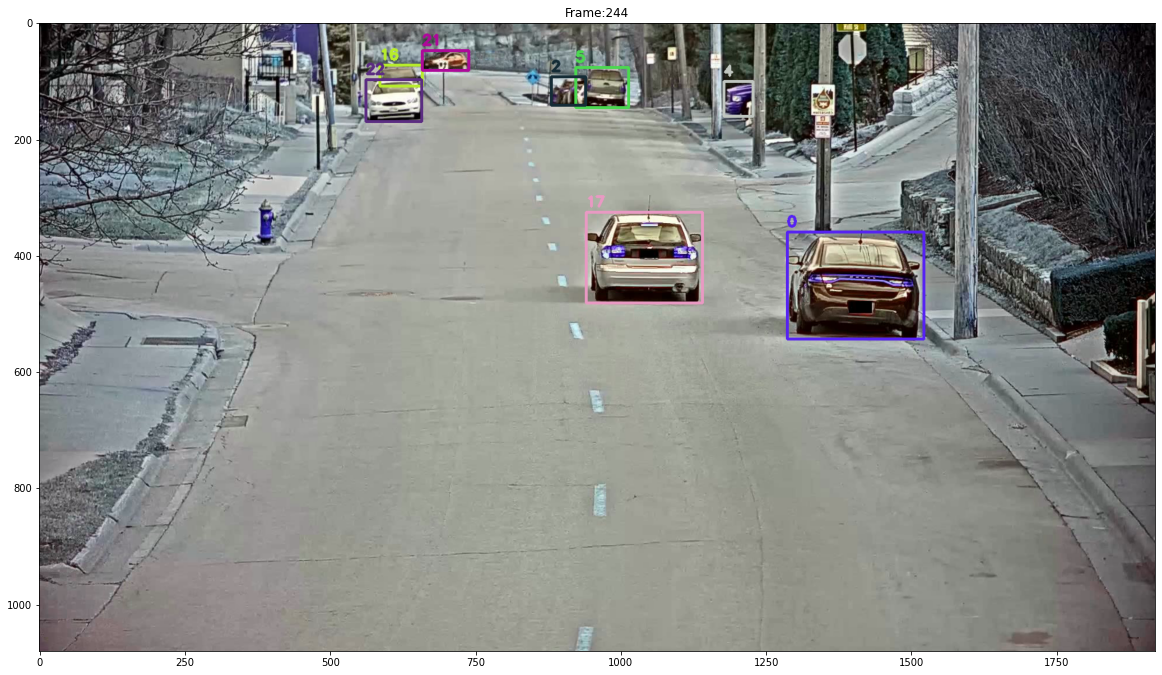

In [9]:
# Iterate Frames
display = True
ims = []
# Load video
vidcap = cv2.VideoCapture(data_path + 'vdo.avi')
_, image = vidcap.read()
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

if display:
    plt.ion() 
    plt.figure(figsize=(20, 12))
    plt.axis('off') 

for frame in tqdm(range(1,num_frames-1)):
    _, image = vidcap.read()
    
    next_detections_pd = get_detection_dataframe(all_detections[str(frame)])
    
    print(detections_pd)
    
    detections_pd = update_track(detections_pd, next_detections_pd, tolerance=0.5)
    
    print(detections_pd)
    
    for index, row in detections_pd.iterrows():
        image = drawRectangleOnImage(image, row['bbox'], track=row['track'],colour=row['colour'])
        
    if display:
        plt.title('Frame:'+str(frame))
        plt.imshow(image)  
    
    if gif:
        im = ax.imshow(image, animated=True)
        ims.append([im])
        
    if display:
        dp.clear_output(wait=True)
        dp.display(plt.gcf())
        time.sleep(0.000001)
        plt.cla()

if gif:
    ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=10000)
    ani.save(videoName + ".gif", writer=animation.PillowWriter(fps=24))

In [ ]:
# for index, row in detections_pd.iterrows():
#     print(row['colour'])
#     image = drawRectangleOnImage(image, row['bbox'], track=row['track'],colour=row['colour'])

In [ ]:
# plt.figure(figsize=(20, 12))
# plt.imshow(image)

In [ ]:
# #Test......
# test_num = 60
# detections_pd = get_detection_dataframe(all_detections[str(test_num)])
# next_detections_pd = get_detection_dataframe(all_detections[str(test_num+1)])

In [ ]:
detections_pd

In [ ]:
next_detections_pd

In [ ]:
detections_pd = update_track(detections_pd, next_detections_pd, tolerance=0.5)
next_detections_pd